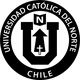

# Laboratorio S02-2: Implementación de una red neuronal simple

## Tópicos avanzados en _Data Science_

**Profesor**: Dr. Juan Bekios Calfa

**Grado**: Diplomado en _Big Data_

# Descripción del problema

Se desea construir un clasificador que prediga el número (digito) de una imagen. Las imágenes utilizadas pertenecen a la base de datos MNIST. Cada imagen tiene un tamaño de $28\times28$ pixeles.



In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 

## Paso 1 : Cargar y visualizar la base de datos MNIST

### Preparar las transformaciones de las imagen

Las imágenes deben ser convertidas de formato PIL a una imagen de tipo tensor. También deben ser normalizadas para que sus valores fluctuen entre -1 y +1.

In [3]:
from torchvision import datasets, transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5), (0.5))
])

In [4]:
trainset = datasets.MNIST('data/', train=True, download=True, transform=transform)
testset = datasets.MNIST('data/', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
print(f'Tamaño del conjunto de entrenamiento: {len(trainset)}')
print(f'Tamaño del conjunto de pruebas: {len(testset)}')

Tamaño del conjunto de entrenamiento: 60000
Tamaño del conjunto de pruebas: 10000


Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

Text(0.5, 1.0, '4')

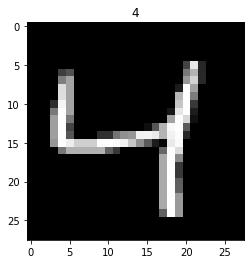

In [6]:
idx = 2
image, label = trainset[idx]
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title(label)

## PASO 2: Dividir la base de datos

Configurar los `DataLoader` el conjunto de entrenamiento, pruebas y validación.

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# Porcentaje para validación
valid_size = 0.2
# Número total de ejemplos en el conjunto de entrenamiento
num_train = len(trainset)
# Seleccionar el indice de corte de los datos
split = int(np.floor(valid_size*num_train))
# Crear indices y desordenarlos para construir el conjunto de entrenamiento y 
# validación
indices = list(range(num_train))
np.random.shuffle(indices)

# Indices para el conjunto de entrenamiento y validación
train_idx, valid_idx = indices[split:], indices[:split]

In [9]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [10]:
# Preparamos los objetos dataloader para realizar los experimentos
trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
validloader = DataLoader(trainset, batch_size=64, sampler=valid_sampler)
testloader = DataLoader(trainset, batch_size=64, shuffle=True)


In [11]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [12]:
print(f'Batches en Trainloader: {len(trainloader)}')
print(f'Batches en Validloader:{len(validloader)}')
print(f'Batches en Testloader: {len(testloader)}')

Batches en Trainloader: 750
Batches en Validloader:188
Batches en Testloader: 938


In [13]:
print(f'Ejemplos en Trainloader: {len(trainloader.sampler)}')
print(f'Ejemplos en Validloader: {len(validloader.sampler)}')
print(f'Ejemplos en Testloader: {len(testloader.sampler)}')

Ejemplos en Trainloader: 48000
Ejemplos en Validloader: 12000
Ejemplos en Testloader: 60000


## Paso 3: Implementando el modelo de redes neuronales artificiales

In [14]:
from torch import nn
import torch.nn.functional as F

class RedPocoProfunda(nn.Module):
    
    def __init__(self):
        super(RedPocoProfunda,self).__init__()
        
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p = 0.4)
    
    def forward(self, images):
        images = images.view(images.shape[0], -1) #[64,1,28,28] -> [64,784]
        
        z1 = self.linear1(images)
        a1 = F.relu(z1)
        
        z2 = self.linear2(a1)
        a2 = F.relu(z2)
        
        z3 = self.linear3(a2)
        a3 = F.log_softmax(z3, dim=1)
        
        return a3

In [15]:
model = RedPocoProfunda()
model

RedPocoProfunda(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [16]:
from torchsummary import summary

summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.90
Estimated Total Size (MB): 0.90
----------------------------------------------------------------


## Paso 4: Entrenando el modelo de redes neuronales artificiales

In [18]:
from torch import optim
from utils import multiclass_accuracy, view_classify

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epochs = 10

In [20]:
train_losses = []
valid_losses = []

for e in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    
    model.train()
    
    for images, labels in trainloader:
        log_prediction = model(images)
        optimizer.zero_grad()
        loss = criterion(log_prediction, labels)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()
    
    model.eval()
    
    for images, labels in validloader:
        log_prediction = model(images)
        prediction = torch.exp(log_prediction)
        loss = criterion(log_prediction, labels)
        valid_acc += multiclass_accuracy(prediction, labels)
        valid_loss += loss.item()
        
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    valid_acc = valid_acc/len(validloader)
    
    print(f'Epoch: {e+1} Train loss: {train_loss:.4f} Valid loss: {valid_loss:.4f} Valid acc: {valid_acc:.4f}')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)      

Epoch: 1 Train loss: 0.0812 Valid loss: 0.1475 Valid acc: 0.9638
Epoch: 2 Train loss: 0.0724 Valid loss: 0.1721 Valid acc: 0.9601
Epoch: 3 Train loss: 0.0736 Valid loss: 0.1163 Valid acc: 0.9720
Epoch: 4 Train loss: 0.0645 Valid loss: 0.1469 Valid acc: 0.9640
Epoch: 5 Train loss: 0.0632 Valid loss: 0.1447 Valid acc: 0.9639
Epoch: 6 Train loss: 0.0676 Valid loss: 0.1210 Valid acc: 0.9683
Epoch: 7 Train loss: 0.0564 Valid loss: 0.1401 Valid acc: 0.9673
Epoch: 8 Train loss: 0.0602 Valid loss: 0.1577 Valid acc: 0.9633
Epoch: 9 Train loss: 0.0628 Valid loss: 0.1635 Valid acc: 0.9623
Epoch: 10 Train loss: 0.0615 Valid loss: 0.1329 Valid acc: 0.9714


#### Visualizamos la pérdida del conjunto de entrenamiento y el de validación

Text(0, 0.5, 'Pérdida (loss)')

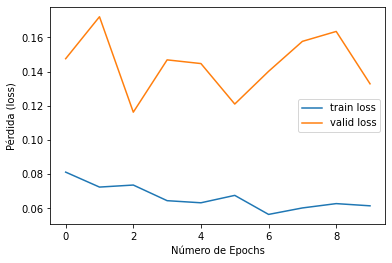

In [23]:
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='valid loss')
plt.legend()
plt.xlabel('Número de Epochs')
plt.ylabel('Pérdida (loss)')

## Paso 5: Evaluamos el modelo

In [ ]:
model.eval()

test_loss = 0.0
test_acc = 0.0

for images, labels in testloader:
    log_prediction = model(images)
    prediction = torch.exp(log_prediction)
    loss = criterion(log_prediction, labels)
    test_acc += multiclass_accuracy(prediction, labels)
    test_loss += loss.item()
    
test_loss = test_loss/len(testloader)
test_acc = test_acc/len(testloader)

print(f'Test loss: {test_loss} Test acc: {test_acc}')

Test loss: 0.06304493571146588 Test acc: 0.9822594523429871


#### Calculamos la predicción desde el conjunto de pruebas

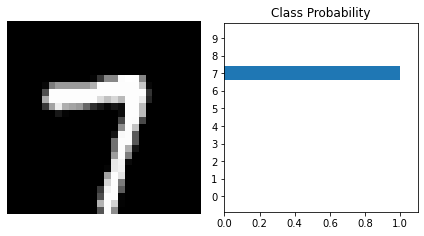

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

idx = 63
log_prediction = model(images[idx])
prediction = torch.exp(log_prediction)

view_classify(images[idx], prediction)